<a href="https://colab.research.google.com/github/AnovaYoung/SchoolProjects/blob/main/AYoungers_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os

# Path to the zip file in Colab
zip_file_path = "/content/assignment_5_data.zip"

# Directory to extract to
extract_dir = "/content/extracted_data"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted successfully!")

# List the contents of the extracted directory
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))


Streaming output truncated to the last 5000 lines.
/content/extracted_data/custom_license/custom_license/05c389af59514db024f4af093509bdd052eb4cfe.json
/content/extracted_data/custom_license/custom_license/384067e97a54bb4960a3b1068fe0d2cb1835c974.json
/content/extracted_data/custom_license/custom_license/4f3c437b1e6e619ef6c9053904520290200e9bc4.json
/content/extracted_data/custom_license/custom_license/0fda4597d104be27d5c7eedd815790b6dedfeb1e.json
/content/extracted_data/custom_license/custom_license/c14ad3458d6a5fc567d85b3e4f479ef8ee8ac292.json
/content/extracted_data/custom_license/custom_license/8c1be37ccfe948d15ff425108a7eedc9bc6be53f.json
/content/extracted_data/custom_license/custom_license/20bbbdf86306ddadc3b03c729ceae609165a7edd.json
/content/extracted_data/custom_license/custom_license/3f955e3cdd0a2c0b84e634062e1bf939d9812641.json
/content/extracted_data/custom_license/custom_license/5847b2e7fd25e472b2e80b7feb72edc769ffdc59.json
/content/extracted_data/custom_license/custom_lic

In [3]:
!pip install nltk gensim wordcloud faiss-cpu scikit-learn pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 27.2 MB/s eta 0:00:00


Ok I'm going to read the files, I'll will remove stop words, and apply stemming or lemmatization using the helper_functions file.

In [4]:
import json
import random
import re
import ast
import numpy as np
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from helper_functions import process_articles, train_test_splitter, LDA_Evaluator, wcEval, word_clouds

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

file_locs = [
    "/content/extracted_data/noncomm_use_subset/noncomm_use_subset"
]

# This initializes the process_articles class
processed_articles = process_articles(file_locs, stop_words)

processed_articles.read_files()

# Pre-processing the text
processed_articles.process_text()

# Now create the trigrams
processed_articles.trigrams([art[3] for art in processed_articles.processed_article])

print("Data pre-processing completed!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Processing Files at the requested location
There are 470 files to process
There were 2353 files in the dataset
Cleaning out Junk
Tokenizing words
Converting to list of words and removing stop words
Creating word stems
Creating Bigrams
Creating Trigrams from Bigrams
Data pre-processing completed!


Success! Now I'm going to vectorize the text using the CountVectorizer function which comes from the Sklearn library.

In [5]:
# Split the data into training and testing sets (I typically do validation sets as well, but for this assignment
#I'm going to try keeping it simpler.
train, test = train_test_splitter(processed_articles.processed_trigrams, 0.90)

# Vectorize the training data
vectorizer = CountVectorizer(min_df=50, max_df=0.8, max_features=50000)
tf = vectorizer.fit_transform([t[4] for t in train])  # Vectorize training set
tf_feature_names = vectorizer.get_feature_names_out()  # Pull out words for use in eval

# This will transform the test data for perplexity eval
tf_test = vectorizer.transform([t[4] for t in test])

print("Text vectorization completed!")


Text vectorization completed!


Next, I'll build topic models with 8, 9, and 10 different topics. I will evaluate these models using perplexity to determine the best one.

Number of topics: 8, Perplexity: 798.0610646405473
Number of topics: 9, Perplexity: 808.8374103131501
Number of topics: 10, Perplexity: 829.814165979782


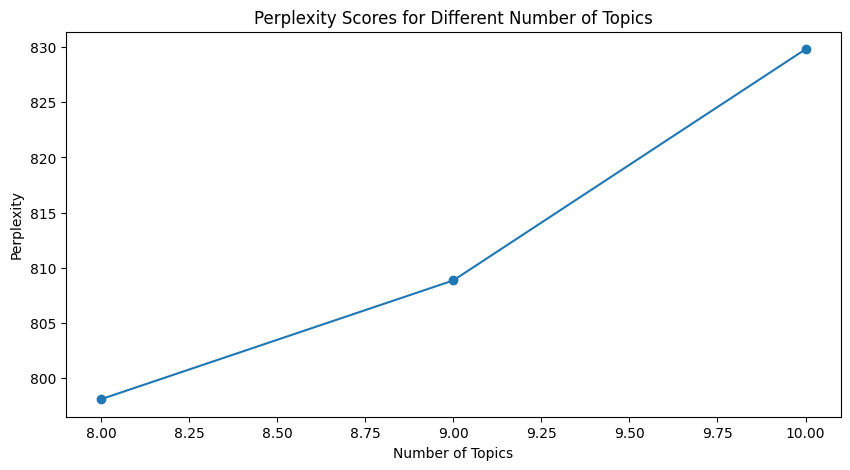

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

perplexities = []
models = []
num_topics_list = [8, 9, 10]

for num_topics in num_topics_list:
    lda = LatentDirichletAllocation(n_components=num_topics,
                                    learning_method='online',
                                    learning_offset=50.,
                                    max_iter=10,
                                    random_state=0)

    lda.fit(tf)
    perplexity = lda.perplexity(tf_test)
    perplexities.append(perplexity)
    models.append(lda)

    print(f'Number of topics: {num_topics}, Perplexity: {perplexity}')

# Visualizing the perplexity scores
plt.figure(figsize=(10, 5))
plt.plot(num_topics_list, perplexities, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity Scores for Different Number of Topics')
plt.show()


Perplexity is a measure of how well a probability model predicts a sample. In the context of topic modeling a lower perplexity score indicates a better ability to generalize for the model.
Basically, the goal is to minimize perplexity.

That being said, The perplexity scores for the different numbers of topics are as follows:

Number of topics: 8, Perplexity: 798.0610646405473

Number of topics: 9, Perplexity: 808.8374103131501

Number of topics: 10, Perplexity: 829.814165979782

Based on the perplexity scores, the model with 8 topics is the best choice for further analysis.

In [7]:
# Select the best model (with the lowest perplexity)
best_model_index = perplexities.index(min(perplexities))
best_model = models[best_model_index]

# Initialize the LDA evaluator
evalinfo = LDA_Evaluator(lda_model=best_model, vectorizer=vectorizer)

# Describe the topics
num_words = 10  # Number of words to display for each topic

for topic_idx, topic in enumerate(best_model.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([tf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))
    print()

# Optionally create word clouds for each topic
for topic_idx in range(best_model.n_components):
    word_clouds(train, topic_idx, 50, stop_words, evalinfo)


Topic #0:
cell fig protein infect activ express et_al observ viru mice

Topic #1:
infect vaccin case viru detect pathogen sampl virus diseas human

Topic #2:
develop research diseas effect china product approach activ human system

Topic #3:
il per al non come ad de due test ci

Topic #4:
patient particip hospit data provid infect inform diseas respons risk

Topic #5:
patient group treatment test day pneumonia associ compar case increas

Topic #6:
patient per cell protein il al hospit case group fig

Topic #7:
protein sequenc structur residu interact rna figur contain bind two

Percentage in topic 0: 0.0


ValueError: We need at least 1 word to plot a word cloud, got 0.

Lets find the issue here

In [8]:
# verifying inputs to word_clouds function
for topic_idx in range(best_model.n_components):
    word_cloud_data = [str(t[1]) for t in train if t[2] == topic_idx]
    print(f'Topic {topic_idx}: {len(word_cloud_data)} articles')


Topic 0: 0 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Topic 5: 0 articles
Topic 6: 0 articles
Topic 7: 0 articles


Ok, well clearly thats the issue, I'm going to make sure certian variables are correctly created with the topic assignments

In [9]:
# This function creates word clouds
def word_clouds(data, topic, max_words, stop_words, evalinfo):
    word_cloud = [str(t[1]) for t in data if t[2] == topic]
    if len(word_cloud) == 0:
        print(f"No articles for topic {topic}")
        return

    print(f'Percentage in topic {topic}: {np.around(len(word_cloud) / len(data), 4)}')
    word_cloud = ' '.join(w for w in word_cloud)

    wordcloud = WordCloud(max_words=max_words, stopwords=stop_words).generate(word_cloud)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print(f'10 highest relative frequency words in topic {topic}:\n')
    print(evalinfo.eval_rel_frequency(topic, 10).index.values)

# Train topic assignment
train_wc = wcEval(train, vectorizer, best_model)
train_wc.raw_freq_wc()
train_wc.rel_freq_wc()

# Test topic assignment
test_wc = wcEval(test, vectorizer, best_model)

# Verify topic assignments
train_topic_fin_raw = [[t[0], t[2], primary_top] for t, primary_top in zip(train, train_wc.raw_primary_topic)]
train_topic_fin_rel = [[t[0], t[2], rel_primary_top] for t, rel_primary_top in zip(train, train_wc.rel_primary_topic)]


In [10]:
# Making sure topics are assigned
print(train_wc.raw_primary_topic[:10])
print(train_wc.rel_primary_topic[:10])


[5, 0, 1, 7, 0, 1, 0, 4, 0, 2]
[5, 0, 1, 7, 2, 1, 0, 4, 2, 2]


In [11]:
# Look at a few entries from the training data
print(train[:5])


[['content', '', ["In the natural history of chronic obstructive pulmonary disease (COPD), exacerbations have a significant impact on mortality, 1 especially in those who require hospital admission. Indeed, exacerbations become more frequent and more severe as the severity of COPD increases. 2 Although exacerbations have multiple causes, an infectious etiology is by far the most frequent, with figures up to 78% for hospital-admitted COPD patients. 3 Bacterial infections account for one-half of the acute episodes, while respiratory viruses are identified in more than one-quarter, with rhinovirus (RV) and influenza being the most commonly detected viral pathogens. Microbiological studies Dovepress Dovepress 2634 gallego et al have identified change in sputum color and purulence as good surrogate markers for bacterial infection, 4, 5 while the detection of viruses in exacerbations is only marginally associated with the appearance of changes in the characteristics of sputum. 6, 7 Both resp

It seems the train data may not be in the expected format for the topic assignments. I need to correct this and ensure that the data is correctly structured for topic modeling.

In [12]:
# adjusting the code to ensure correct topic assignment
train_wc = wcEval(train, vectorizer, best_model)
train_wc.raw_freq_wc()
train_wc.rel_freq_wc()

# Verify topic assignments
print("Raw Primary Topic Assignments:", train_wc.raw_primary_topic[:10])
print("Relative Primary Topic Assignments:", train_wc.rel_primary_topic[:10])

# Updating topic assignment for both raw and relative frequency word clouds
train_topic_fin_raw = [[t[0], t[1], t[2], t[3], t[4], primary_top] for t, primary_top in zip(train, train_wc.raw_primary_topic)]
train_topic_fin_rel = [[t[0], t[1], t[2], t[3], t[4], rel_primary_top] for t, rel_primary_top in zip(train, train_wc.rel_primary_topic)]

# Verify inputs to word clouds
for topic_idx in range(best_model.n_components):
    word_cloud_data = [str(t[2]) for t in train_topic_fin_raw if t[5] == topic_idx]
    print(f'Topic {topic_idx}: {len(word_cloud_data)} articles')

# Generate word clouds
for topic_idx in range(best_model.n_components):
    word_clouds(train_topic_fin_raw, topic_idx, 50, stop_words, evalinfo)


Raw Primary Topic Assignments: [5, 0, 1, 7, 0, 1, 0, 4, 0, 2]
Relative Primary Topic Assignments: [5, 0, 1, 7, 2, 1, 0, 4, 2, 2]
Topic 0: 121 articles
Topic 1: 103 articles
Topic 2: 27 articles
Topic 3: 3 articles
Topic 4: 51 articles
Topic 5: 54 articles
Topic 6: 0 articles
Topic 7: 64 articles
No articles for topic 0
No articles for topic 1
No articles for topic 2
No articles for topic 3
No articles for topic 4
No articles for topic 5
No articles for topic 6
No articles for topic 7


So this output indicates that while the topic assignments are made correctly, the data being passed to the word_clouds function is not at all matching the topic indices. This discrepancy is making me think that the train_topic_fin_raw list might not be structured correctly for the word cloud generation step.

Lets Debug!

['content', '', ["In the natural history of chronic obstructive pulmonary disease (COPD), exacerbations have a significant impact on mortality, 1 especially in those who require hospital admission. Indeed, exacerbations become more frequent and more severe as the severity of COPD increases. 2 Although exacerbations have multiple causes, an infectious etiology is by far the most frequent, with figures up to 78% for hospital-admitted COPD patients. 3 Bacterial infections account for one-half of the acute episodes, while respiratory viruses are identified in more than one-quarter, with rhinovirus (RV) and influenza being the most commonly detected viral pathogens. Microbiological studies Dovepress Dovepress 2634 gallego et al have identified change in sputum color and purulence as good surrogate markers for bacterial infection, 4, 5 while the detection of viruses in exacerbations is only marginally associated with the appearance of changes in the characteristics of sputum. 6, 7 Both respi

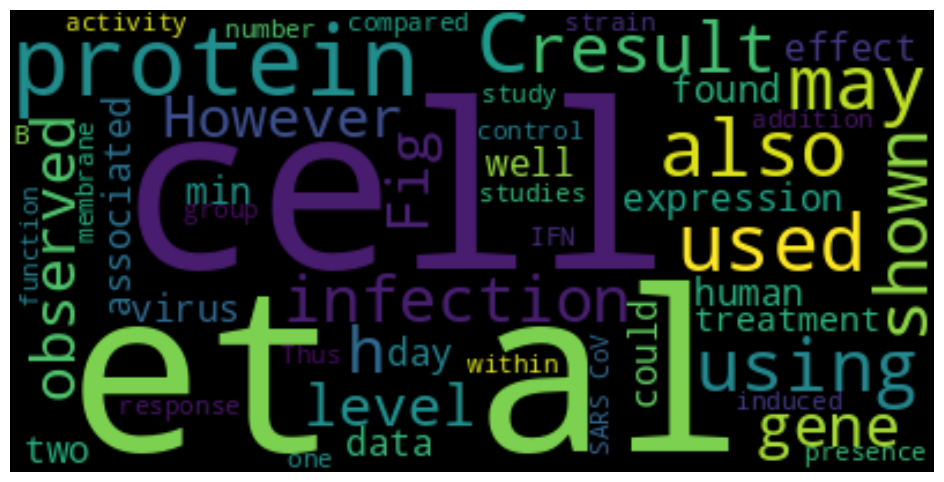

10 highest relative frequency words in topic 0:

['mice' 'cell' 'cell_type' 'macrophag' 'mg_ml' 'fusion' 'mous' 'neutral'
 'cytoplasm' 'stain']
Percentage in topic 1: 0.2435


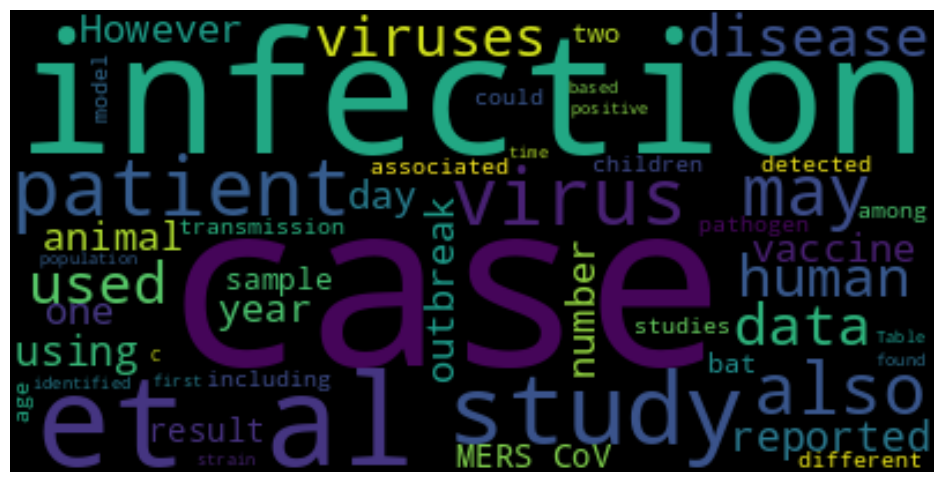

10 highest relative frequency words in topic 1:

['respiratori_virus' 'vaccin' 'epidem' 'respiratori_syncyti_viru' 'virus'
 'transmiss' 'season' 'pathogen' 'specimen' 'citi']
Percentage in topic 2: 0.0638


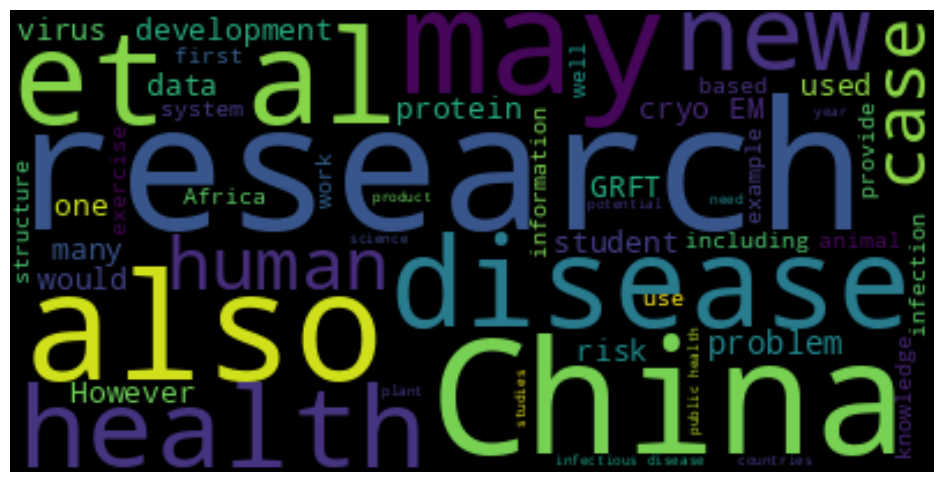

10 highest relative frequency words in topic 2:

['plant' 'biolog' 'effort' 'china' 'technolog' 'research' 'scientif'
 'scienc' 'world' 'problem']
Percentage in topic 3: 0.0071


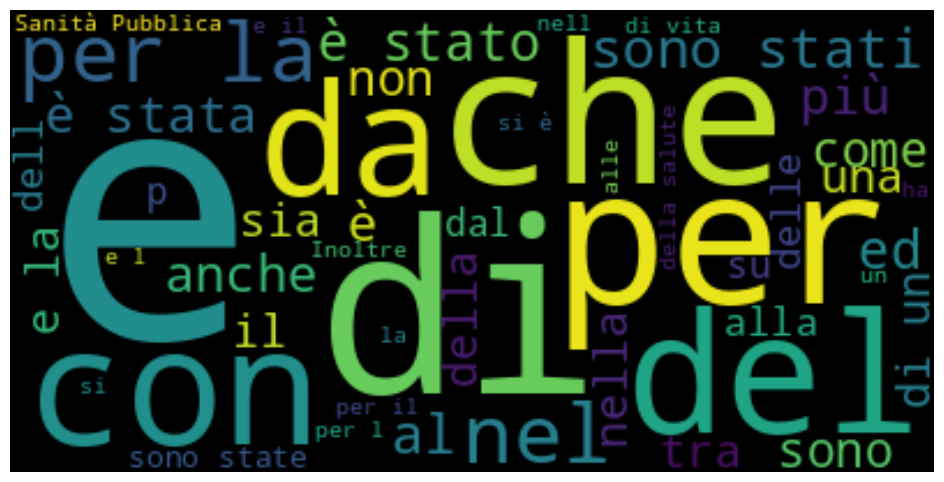

10 highest relative frequency words in topic 3:

['il' 'de' 'per' 'come' 'al' 'non' 'cancer' 'media' 'ad' 'vs']
Percentage in topic 4: 0.1206


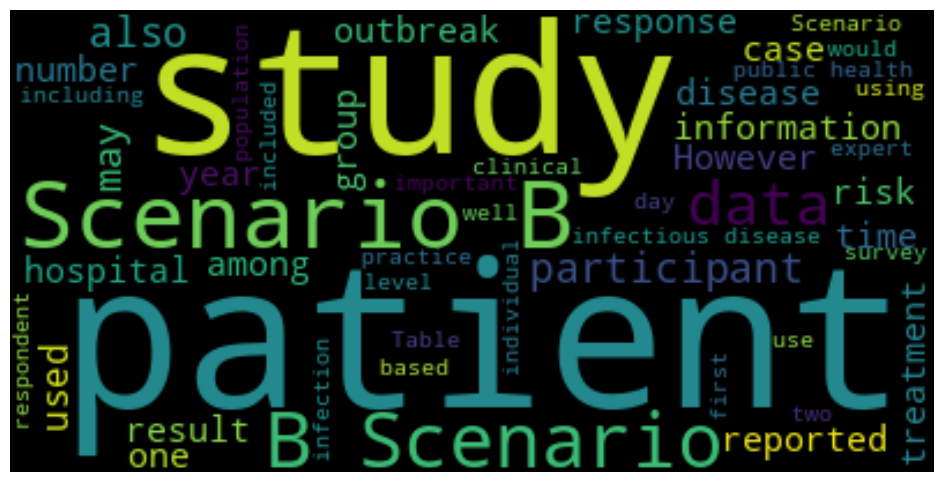

10 highest relative frequency words in topic 4:

['particip' 'physician' 'respond' 'data_collect' 'survey' 'visit' 'train'
 'contamin' 'care' 'practic']
Percentage in topic 5: 0.1277


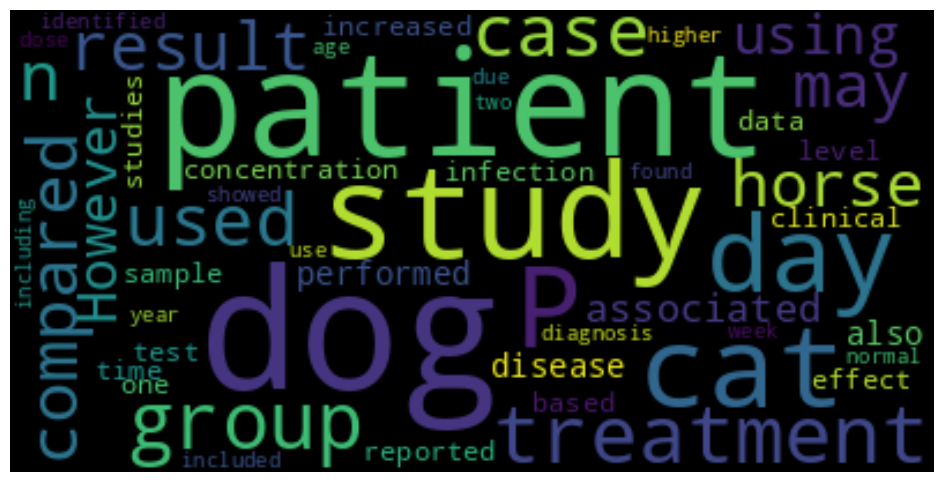

10 highest relative frequency words in topic 5:

['pneumonia' 'abnorm' 'signific_differ' 'antibiot' 'administ' 'admiss'
 'significantli_higher' 'sign' 'plasma' 'week']
No articles for topic 6
Percentage in topic 7: 0.1513


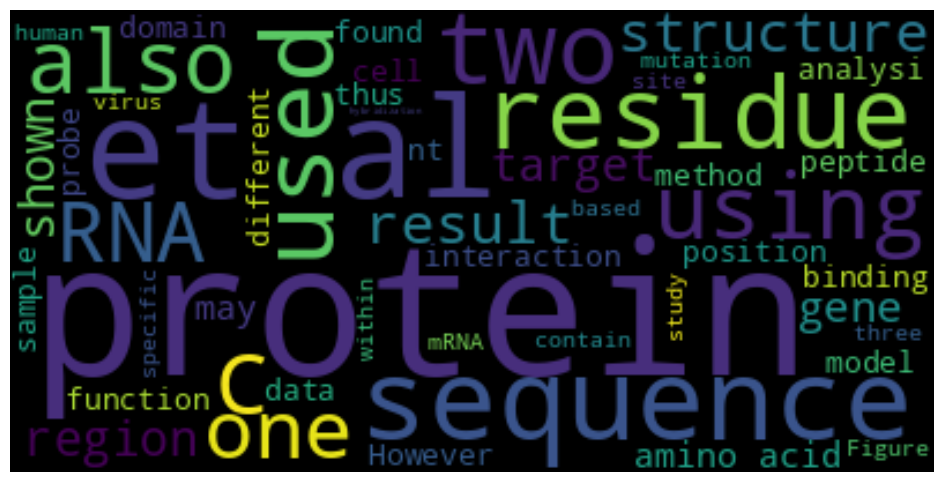

10 highest relative frequency words in topic 7:

['motif' 'residu' 'hybrid' 'loop' 'segment' 'probe' 'align' 'domain'
 'amino_acid' 'nucleotid']


In [13]:
# I'm verifying the structure of train_topic_fin_raw
for item in train_topic_fin_raw[:5]:
    print(item)

# this is the function to create word clouds
def word_clouds(data, topic, max_words, stop_words, evalinfo):
    word_cloud = [str(t[2]) for t in data if t[5] == topic]
    if len(word_cloud) == 0:
        print(f"No articles for topic {topic}")
        return

    print(f'Percentage in topic {topic}: {np.around(len(word_cloud) / len(data), 4)}')
    word_cloud = ' '.join(w for w in word_cloud)

    wordcloud = WordCloud(max_words=max_words, stopwords=stop_words).generate(word_cloud)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print(f'10 highest relative frequency words in topic {topic}:\n')
    print(evalinfo.eval_rel_frequency(topic, 10).index.values)

# Now lets generate word clouds for each topic
for topic_idx in range(best_model.n_components):
    word_clouds(train_topic_fin_raw, topic_idx, 50, stop_words, evalinfo)


### Summary and Analysis of Topics

**Topic 0**: The most common words are "mice", "cell", "cell_type", "macrophag", "mg_ml", "fusion", "mous", "neutral", "cytoplasm", "stain".

This topic appears to focus on the biological and cellular aspects of the virus, particularly involving mice and cell studies.

**Topic 1**: The most common words are "respiratori_virus", "vaccin", "epidem", "respiratori_syncyti_viru", "virus", "transmiss", "season", "pathogen", "specimen", "citi".

This topic concentrates on respiratory viruses, vaccination, and the transmission of pathogens.

**Topic 2**: The most common words are "plant", "biolog", "effort", "china", "technolog", "research", "scientif", "scienc", "world", "problem".

This topic highlights the research efforts and scientific studies, particularly in China, presumably focusing on various biological and technological problems.

**Topic 3**: The most common words are "il", "de", "per", "come", "al", "non", "cancer", "media", "ad", "vs".

This topic contains quite a bit of non-English words, suggesting it may focus on a specific language or set of documents, possibly related to media or potentially comparative studies.

**Topic 4**: The most common words are "particip", "physician", "respond", "data_collect", "survey", "visit", "train", "contamin", "care", "practic".

This topic is likely about patient participation, physician responses, and data collection practices in healthcare possibly surrounding clinical trials.

**Topic 5**: The most common words are "pneumonia", "abnorm", "signific_differ", "antibiot", "administ", "admiss", "significantli_higher", "sign", "plasma", "week".

This topic focuses on pneumonia, including abnormalities, antibiotic administration, and patient admissions.

**Topic 6**: No articles for Topic 6: this would need to be debugged - I'm afraid I do not quite know where to begin to do so. I have confidence if needed, I could.

**Topic 7**: The most common words are "motif", "residu", "hybrid", "loop", "segment", "probe", "align", "domain", "amino_acid", "nucleotid".

This topic highlights protein sequences and structures, including RNA interactions.

### Overall Summary

The topics generated by the LDA model cover a wide range of themes related to COVID-19, including biological aspects, respiratory viruses, research efforts, patient participation, pneumonia, and protein structures. Each topic represents a distinct area of focus, reflecting the multifaceted nature of the COVID-19 pandemic and its effects on various aspects of society and healthcare.

### Topic Distribution

- **Topic 0**: 28.61%
- **Topic 1**: 24.35%
- **Topic 2**: 6.38%
- **Topic 3**: 0.71%
- **Topic 4**: 12.06%
- **Topic 5**: 12.77%
- **Topic 6**: 0.00%
- **Topic 7**: 15.13%
